In [1]:
import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotx

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

from SparseStochMat import sparse_autocov_mat
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import auxiliary_functions

from scipy.fft import fft, ifft, fftfreq

Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


In [2]:
net = ContTempNetwork.load('periodic_SBM_net')

In [3]:
selected_lamdas = np.logspace(-3,1,10)
windows = [10, 100, 1000]
list_scales = [3, 2, 1, 2, 3, 2, 1, 2, 3]

In [86]:
window = windows[-1]
lamda = selected_lamdas[5]

window_S_selected = []

with open(f'//scratch/tmp/180/skoove/periodic_SBM_heat/window_S_selected/{window}/window_S{lamda:.11f}', 'rb') as f:
    S_rate = pickle.load(f)
    window_S_selected.append(S_rate['window_S'][f'{lamda:.11f}'])

S = window_S_selected[0]

In [87]:
N = len(S[1:])  # Number of samples
dt = (net.times[- (window // 2)] - net.times[(window // 2)+1] ) / len(net.times[(window // 2)+1 : - (window // 2)])

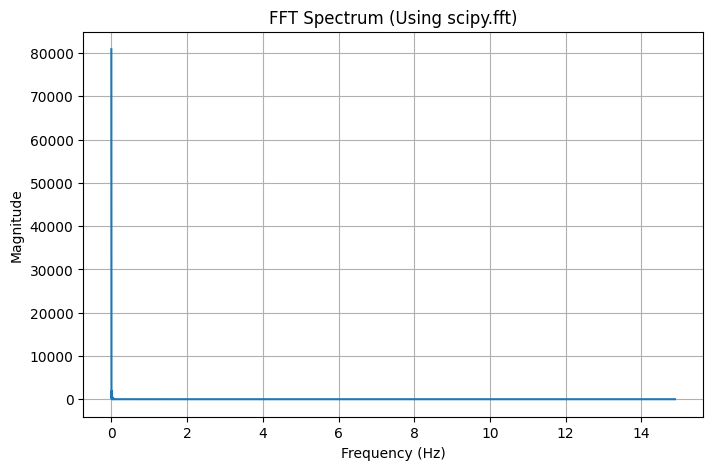

In [88]:
freqs = fftfreq(N, d=dt)  # Frequency axis
fft_vals = fft(S[1:])  # Compute FFT
magnitude = np.abs(fft_vals)  # Magnitude spectrum

# Plot the positive half of the spectrum (since FFT is symmetric for real signals)
plt.figure(figsize=(8, 5))
plt.plot(freqs[:N//2] , magnitude[:N//2])  # Only positive frequencies
plt.xlabel('Frequency (Hz)')

plt.ylabel('Magnitude')
plt.title('FFT Spectrum (Using scipy.fft)')
plt.grid()
plt.show()

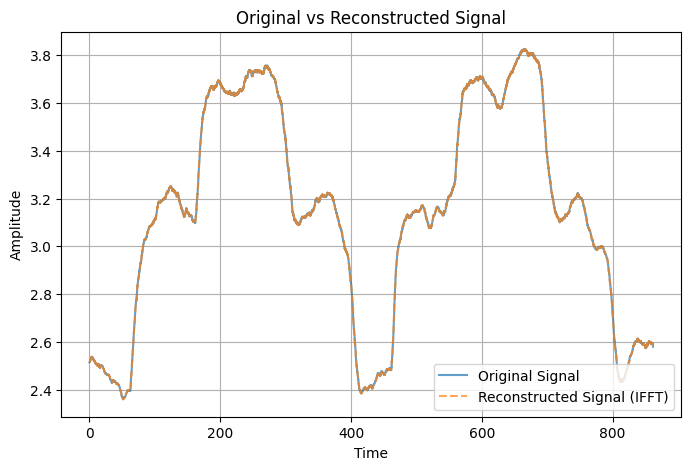

In [89]:

freqs = fftfreq(N, d=dt)  # Frequency axis
fft_vals = fft(S[1:])  # Compute FFT

# Compute inverse FFT
reconstructed_signal = ifft(fft_vals).real  # Taking the real part

# Generate time axis
time = np.arange(N) * dt  # Time vector

# Plot original and reconstructed signals
plt.figure(figsize=(8, 5))
plt.plot(time[:], S[1:], label="Original Signal", alpha=0.7)
plt.plot(time[:], reconstructed_signal, '--', label="Reconstructed Signal (IFFT)", alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Signal')
plt.legend()
plt.grid()
plt.show()

In [90]:
# freqs = fftfreq(N, d=dt)  # Frequency axis
# fft_vals = fft(S[1:])  # Compute FFT
# magnitude = np.abs(np.imag(fft_vals))  # Magnitude spectrum

# mean_magnitude = np.mean(magnitude)
# threshold = 100
# flag_mean = magnitude[:N//2] > mean_magnitude
# flag_threshold = magnitude[:N//2] > threshold

# print(freqs[:N//2][flag_mean])
# print(freqs[:N//2][flag_threshold])

# # Plot the positive half of the spectrum (since FFT is symmetric for real signals)
# plt.figure(figsize=(8, 5))
# plt.scatter(freqs[:N//2][flag_threshold], magnitude[:N//2][flag_threshold])  # Only positive frequencies
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Magnitude')
# plt.title('FFT Spectrum (Using scipy.fft)')
# plt.grid()
# plt.show()

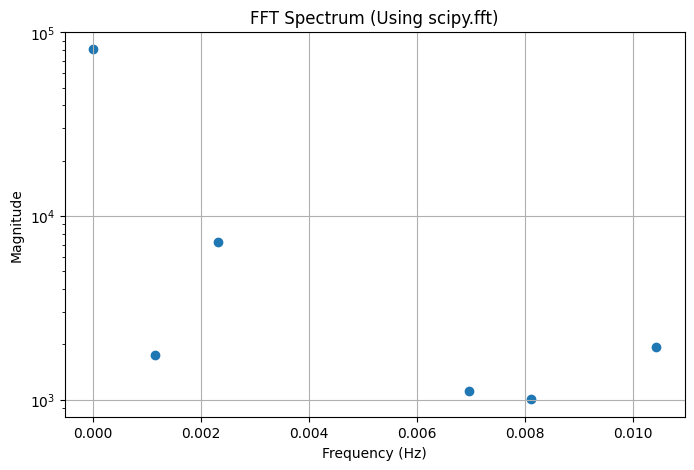

[inf, 861.9012078479554, 430.9506039239777, 143.65020130799257, 123.12874397827935, 95.76680087199506]


/tmp/ipykernel_3510916/4096738571.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  print([ 1 / i for i in freqs[:N//2][flag_threshold]])


In [91]:
freqs = fftfreq(N, d=dt)  # Frequency axis
fft_vals = fft(S[1:])  # Compute FFT
magnitude = np.abs(np.abs(fft_vals))  # Magnitude spectrum

mean_magnitude = np.mean(magnitude)
threshold = 1000
flag_mean = magnitude[:N//2] > mean_magnitude
flag_threshold = magnitude[:N//2] > threshold

#print(freqs[:N//2][flag_mean])
#print(freqs[:N//2][flag_threshold])

# Plot the positive half of the spectrum (since FFT is symmetric for real signals)
plt.figure(figsize=(8, 5))
plt.scatter(freqs[:N//2][flag_threshold], magnitude[:N//2][flag_threshold])  # Only positive frequencies
plt.xlabel('Frequency (Hz)')
plt.yscale('log')
plt.ylabel('Magnitude')
plt.title('FFT Spectrum (Using scipy.fft)')
plt.grid()
plt.show()

print([ 1 / i for i in freqs[:N//2][flag_threshold]])

In [92]:
# fft_vals = fft(S[1:])  # Compute FFT
# magnitude = np.abs(fft_vals)  # Magnitude spectrum

# mean_magnitude = np.mean(magnitude)
# threshold = 1000
# flag_mean = magnitude > mean_magnitude
# flag_threshold = magnitude > threshold

# # Assuming you have S (the original 
# freqs = fftfreq(N, d=dt)  # Frequency axis
# fft_vals_filtered = np.where(magnitude > threshold, fft_vals, 0) # Compute FFT

# # Compute inverse FFT
# reconstructed_signal = ifft(fft_vals_filtered).real  # Taking the real part

# # Generate time axis
# time = np.arange(N) * dt  # Time vector

# # Plot original and reconstructed signals
# plt.figure(figsize=(8, 5))
# plt.plot(time[:], S[1:], label="Original Signal", alpha=0.7)
# plt.plot(time[:], reconstructed_signal, '--', label="Reconstructed Signal (IFFT)", alpha=0.7)
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.title('Original vs Reconstructed Signal')
# plt.legend()
# plt.grid()
# plt.show()

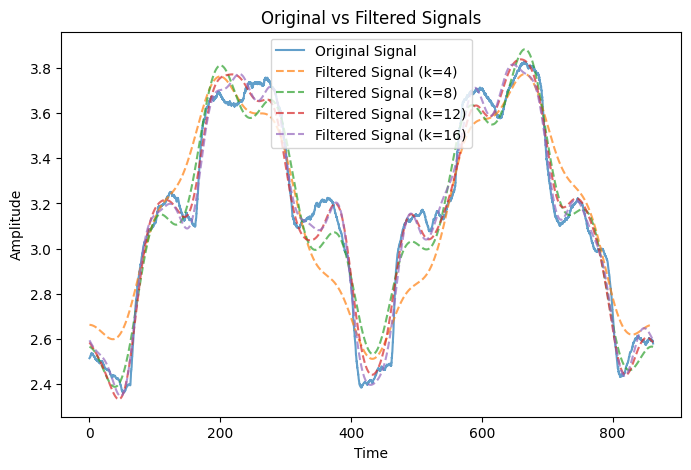

In [93]:
# Plot original and reconstructed signals
plt.figure(figsize=(8, 5))
plt.plot(time, S[1:], label="Original Signal", alpha=0.7)


for k in range(4,20,4):
    #k = 10  # Number of dominant frequencies to keep
    reconstructed_signal, freqs, fft_vals_filtered = auxiliary_functions.filter_signal(S[1:], dt, k)

    # Generate time axis
    dt = (net.times[- (window // 2)] - net.times[(window // 2)+1] ) / len(net.times[(window // 2)+1 : - (window // 2)])
    time = np.arange(len(S[1:])) * dt
    plt.plot(time, reconstructed_signal, '--', label=f"Filtered Signal (k={k})", alpha=0.7)


plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Original vs Filtered Signals')
plt.legend()
#plt.grid()
plt.show()

# Time Scales

In [94]:
# # Example usage:
# indices_to_keep = range(5,9)  # Select specific frequency indices based on magnitude
# reconstructed_signals, freqs = auxiliary_functions.extract_frequencies(S[1:], dt, indices_to_keep)

# # Generate time axis
# time = np.arange(len(S[1:])) * dt

# # Plot each selected frequency component
# plt.figure(figsize=(8, 5))

# i=0
# for idx, signal in reconstructed_signals.items():
#     plt.plot(time, signal, label=f"Freq Index: {indices_to_keep[i]}")
#     i+=1

# # Plot settings
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.title('Reconstructed Signal Components for Selected Frequencies')
# plt.legend()
# plt.grid()
# plt.show()

In [95]:
def top_frequencies(S, dt, number_selected_freqs = 4):
    N = len(S)  # Number of samples
    indices = range(number_selected_freqs + 1)

    # Compute FFT
    fft_vals = fft(S)
    magnitude = np.abs(fft_vals)  # Magnitude spectrum
    magnitude = magnitude[0:(len(magnitude)//2)]

    # Sort frequencies by magnitude and get the corresponding indices
    sorted_indices = np.argsort(magnitude)[::-1]  # Sort in descending order
    selected_indices = sorted_indices[indices]  # Select desired frequencies

    # Generate the frequency axis
    freqs = fftfreq(N, d=dt)

    selected_freqs = freqs[selected_indices]
    if 0 in selected_freqs:
        selected_freqs = [i for i in selected_freqs if i != 0]
    else:
        selected_freqs = selected_freqs[:-1]
    return selected_freqs

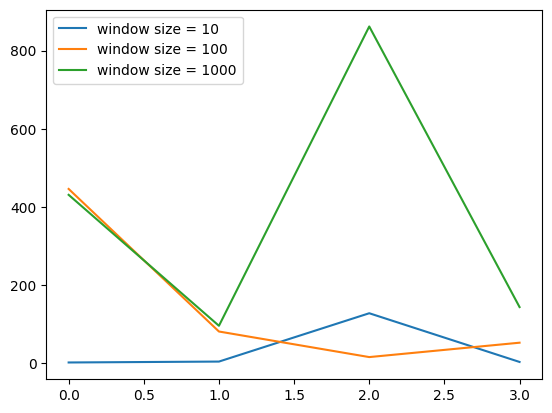

In [96]:
window_S_selected = []
for window in windows:
    with open(f'//scratch/tmp/180/skoove/periodic_SBM_heat/window_S_selected/{window}/window_S{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        window_S_selected.append(S_rate['window_S'][f'{lamda:.11f}'])


for i, window in enumerate(windows):
    S = window_S_selected[i]
    top_freqs = top_frequencies(S, dt, number_selected_freqs = 4)
    time_scales = [1 / freq for freq in top_freqs]
    plt.plot(time_scales, label='window size = ' + str(window))
    plt.legend()

## Change point detection

In [123]:
dSdt = auxiliary_functions.derivative(S[1:], time)
d2Sdt2 = auxiliary_functions.derivative(dSdt, time[1:])
dSdt = dSdt / max(np.abs(dSdt))
d2Sdt2 = d2Sdt2 / max(np.abs(d2Sdt2))

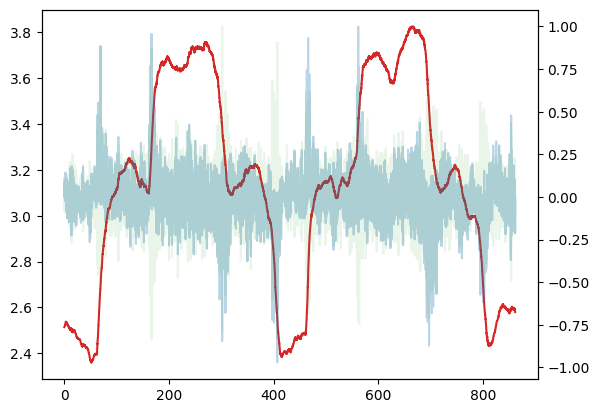

In [127]:
####### Enotrpy Plot
fig, ax = plt.subplots()
color = 'tab:red'
ax.plot(time, S[1:], color=color)


ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(time[1:], dSdt, alpha=0.3, color=color)
color = 'tab:green'
plt.plot(time[1:-1], d2Sdt2, alpha=0.1, color=color)

#ax2.set_xlabel(r'$\lambda$ [s]')
#ax2.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
#ax2.tick_params(axis='y', labelcolor=color)

In [167]:
dSdt = auxiliary_functions.derivative(reconstructed_signal, time)
#delete first values
dSdt = dSdt[1:]
d2Sdt2 = auxiliary_functions.derivative(dSdt, time[1:-1])
#delete first values
d2Sdt2 = d2Sdt2[1:]
#shrink range
dSdt = dSdt / max(np.abs(dSdt))
d2Sdt2 = d2Sdt2 / max(np.abs(d2Sdt2))

Text(0, 0.5, 'Shrinked Derivatives')

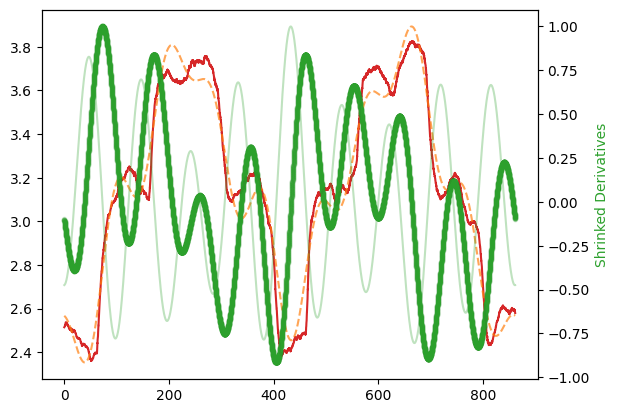

In [185]:
####### Enotrpy Plot
fig, ax = plt.subplots()
color = 'tab:red'
ax.plot(time, S[1:], color=color)
color = 'tab:orange'
ax.plot(time, reconstructed_signal, '--', color =color, alpha = 0.7,)


ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.plot(time[2:], dSdt, '.', alpha=0.1, color=color)
color = 'tab:green'
plt.plot(time[2:-2], d2Sdt2, alpha=0.3, color=color)

#ax2.set_xlabel(r'$\lambda$ [s]')
ax2.set_ylabel('Shrinked Derivatives', color=color)  # we already handled the x-label with ax1
#ax2.tick_params(axis='y', labelcolor=color)

Text(0, 0.5, 'Shrinked Derivatives')

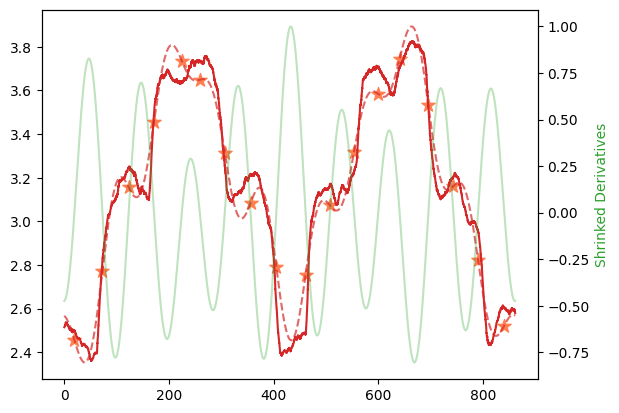

In [200]:
####### Enotrpy Plot
fig, ax = plt.subplots()
color = 'tab:red'
ax.plot(time, S[1:], color=color)
color = 'tab:red'
ax.plot(time, reconstructed_signal, '--', color =color, alpha = 0.7,)


ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis


color = 'tab:green'
ax2.plot(time[2:-2], d2Sdt2, alpha=0.3, color=color)

zero_crossings = np.where(np.diff(np.sign(d2Sdt2)))[0]

ax.scatter(time[3:-2][zero_crossings], reconstructed_signal[zero_crossings+3], color="coral", marker="*", s=100, label="Local zero_crossings")
#for idx in zero_crossings:
    #ax.axvline(x=time[3:-2][idx], ymax=reconstructed_signal[idx+3] / 5., color="coral", linestyle="--", alpha=0.6)

#ax2.set_xlabel(r'$\lambda$ [s]')
ax2.set_ylabel('Shrinked Derivatives', color=color)  # we already handled the x-label with ax1

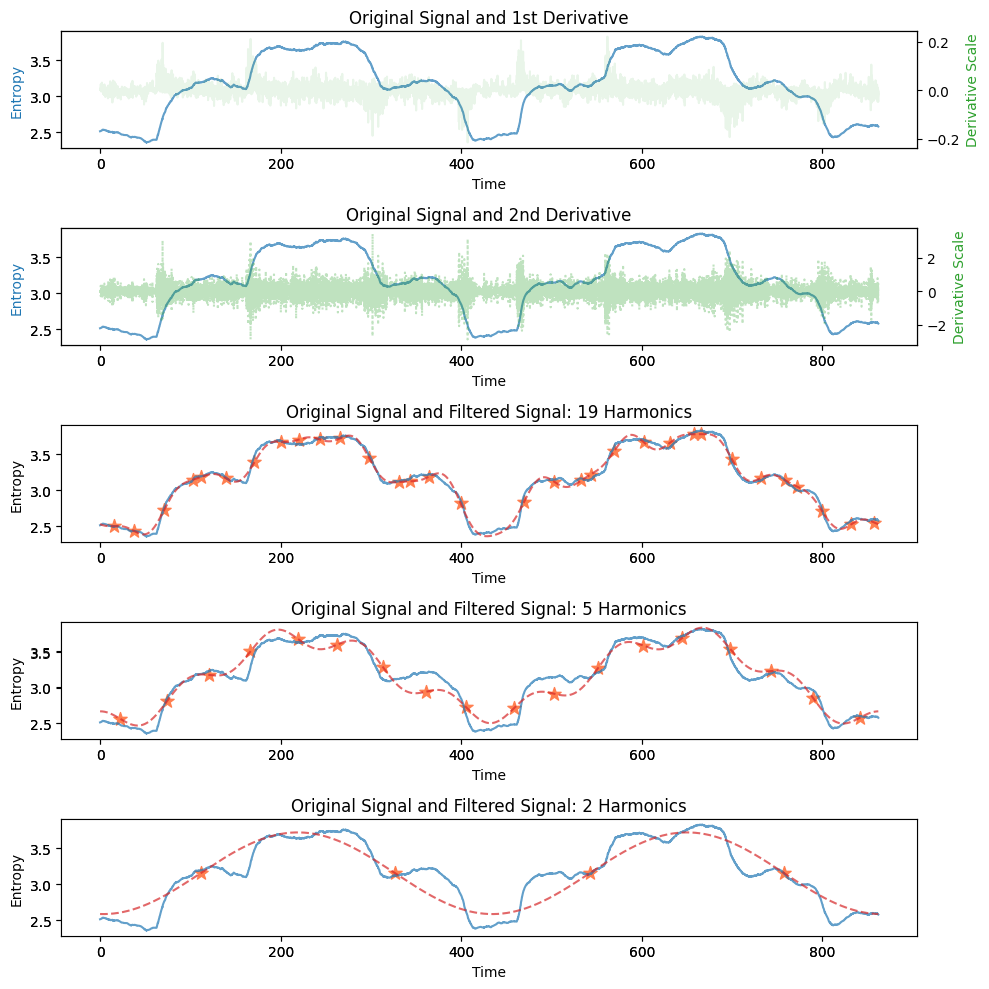

In [ ]:
#Computation of derviatives

dSdt = auxiliary_functions.derivative(S[1:], time)
#delete first values
dSdt = dSdt[1:]
d2Sdt2 = auxiliary_functions.derivative(dSdt, time[1:-1])
#delete first values
d2Sdt2 = d2Sdt2[1:]

# Start creating the figure
fig = plt.figure(figsize=(10, 10))  # Wider figure for all plots in one row
gs = fig.add_gridspec(5, 1)  # Grid: 5 row,  1 columns

#plot signal on every subplot
for i in range(5):
    ax_a = fig.add_subplot(gs[i, 0])
    ax_a.plot(time, S[1:], alpha=0.7)

#Add Derivative to first plot
ax_a = fig.add_subplot(gs[0, 0])
color = 'tab:blue'
ax_a.plot(time, S[1:], alpha=0.7, color=color)
ax_a.set_xlabel('Time')
ax_a.set_ylabel('Entropy', color=color)
ax_a.set_title('Original Signal and 1st Derivative')

ax2 = ax_a.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.plot(time[2:], dSdt, alpha=0.1, color=color)
ax2.set_ylabel('Derivative Scale', color=color)

#Add 2nd Derivative to second plot
ax_a = fig.add_subplot(gs[1, 0])

color = 'tab:blue'
ax_a.plot(time, S[1:], alpha=0.7, color=color)
ax_a.set_xlabel('Time')
color = 'tab:blue'
ax_a.set_ylabel('Entropy', color=color)
ax_a.set_title('Original Signal and 2nd Derivative')

ax2 = ax_a.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.plot(time[2:-2], d2Sdt2, ':', alpha=0.3, color=color)
ax2.set_ylabel('Derivative Scale', color=color)  

# Column 1: Plot A
for ax_index, k in enumerate([20,6,3]):
    ax_a = fig.add_subplot(gs[ax_index + 2, 0])
    color = 'tab:blue'
    ax_a.plot(time, S[1:], alpha=0.7, color=color)
    #k -1 = # Number of dominant frequencies to keep (-1 beacause of intercept)
    reconstructed_signal, freqs, fft_vals_filtered = auxiliary_functions.filter_signal(S[1:], dt, k)
    # Generate time axis
    dt = (net.times[- (window // 2)] - net.times[(window // 2)+1] ) / len(net.times[(window // 2)+1 : - (window // 2)])
    time = np.arange(len(S[1:])) * dt
    color = 'tab:red'
    ax_a.plot(time, reconstructed_signal, '--', alpha=0.7, color=color)
    ax_a.set_xlabel('Time')
    ax_a.set_ylabel('Entropy')
    ax_a.set_title(f"Original Signal and Filtered Signal: {k-1} Harmonics")


    dSdt = auxiliary_functions.derivative(reconstructed_signal, time)
    #delete first values
    dSdt = dSdt[1:]
    d2Sdt2 = auxiliary_functions.derivative(dSdt, time[1:-1])
    #delete first values
    d2Sdt2 = d2Sdt2[1:]
    #shrink range
    dSdt = dSdt / max(np.abs(dSdt))
    d2Sdt2 = d2Sdt2 / max(np.abs(d2Sdt2))
        

    zero_crossings = np.where(np.diff(np.sign(d2Sdt2)))[0]

    ax_a.scatter(time[3:-2][zero_crossings], reconstructed_signal[zero_crossings+3], color="coral", marker="*", s=100, label="Local zero_crossings")
    #for idx in zero_crossings:
        #ax.axvline(x=time[3:-2][idx], ymax=reconstructed_signal[idx+3] / 5., color="coral", linestyle="--", alpha=0.6)




# Adjust layout and display
plt.tight_layout()
#plt.savefig('/home/b/skoove/Desktop/periodic_SBM/periodic_SBM_fourier_fig.png', format='png', dpi=300, bbox_inches='tight')
plt.show()